# Spleen 3D segmentation with MONAI

This tutorial demonstrates how MONAI can be used in conjunction with the [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) framework.

We demonstrate use of the following MONAI features:
1. Transforms for dictionary format data.
1. Loading Nifti images with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scaling medical image intensity with expected range.
1. Croping out a batch of balanced images based on  the positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. Use of a a 3D UNet model, Dice loss function, and mean Dice metric for a 3D segmentation task.
1. The sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/MONAI/blob/master/examples/notebooks/spleen_segmentation_3d_lightning.ipynb)

## Setup environment

In [1]:
%pip install -qU "monai[gdown, nibabel]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qU matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q pytorch-lightning

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install -q ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [5]:
! jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Setup imports

In [6]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import os
import shutil
import tempfile

import IPython
import matplotlib.pyplot as plt
import pytorch_lightning
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, list_data_collate
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.2.0
Python version: 3.7.5 (default, Nov  7 2019, 10:50:52)  [GCC 8.3.0]
Numpy version: 1.19.1
Pytorch version: 1.6.0

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 7.2.0
Tensorboard version: 2.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [7]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/bengorman/notebooks/


## Download dataset

Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

In [8]:
resource = "https://drive.google.com/uc?id=1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")

download_and_extract(resource, compressed_file, root_dir, md5)

file /home/bengorman/notebooks/Task09_Spleen.tar exists, skip downloading.
extracted file /home/bengorman/notebooks/Task09_Spleen exists, skip extracting.


## Define the LightningModule

The LightningModule contains a refactoring of your training code. The following module is a refactoring of the code in `spleen_segmentation_3d.ipynb`: 

In [9]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        )
        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.best_val_dice = 0
        self.best_val_epoch = 0

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # set up the correct data path
        train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
        train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
        data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)
        ]
        train_files, val_files = data_dicts[:-9], data_dicts[-9:]

        # set deterministic training for reproducibility
        set_determinism(seed=0)

        # define the data transforms
        train_transforms = Compose(
            [
                LoadNiftid(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                # randomly crop out patch samples from big image based on pos / neg ratio
                # the image centers of negative samples must be in valid image area
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(96, 96, 96),
                    pos=1,
                    neg=1,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),
                # user can also add other random transforms
                # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
                #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
                ToTensord(keys=["image", "label"]),
            ]
        )
        val_transforms = Compose(
            [
                LoadNiftid(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        )

        # we use cached datasets - these are 10x faster than regular datasets
        self.train_ds = CacheDataset(
            data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4,
        )
        self.val_ds = CacheDataset(
            data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4,
        )
        # self.train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
        # self.val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(self.val_ds, batch_size=1, num_workers=4)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        value = compute_meandice(
            y_pred=outputs,
            y=labels,
            include_background=False,
            to_onehot_y=True,
            mutually_exclusive=True,
        )
        return {"val_loss": loss, "val_dice": value}

    def validation_epoch_end(self, outputs):
        val_dice, val_loss, num_items = 0, 0, 0
        for output in outputs:
            val_dice += output["val_dice"].sum().item()
            val_loss += output["val_loss"].sum().item()
            num_items += len(output["val_dice"])
        mean_val_dice = torch.tensor(val_dice / num_items)
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}

## Run the training

In [10]:
# initialise the LightningModule
net = Net()

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=log_dir
)
checkpoint_callback = pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint(
    filepath=os.path.join(log_dir, "{epoch}-{val_loss:.2f}-{val_dice:.2f}")
)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=600,
    logger=tb_logger,
    checkpoint_callback=checkpoint_callback,
    show_progress_bar=False,
    num_sanity_val_steps=1,
)

# train
trainer.fit(net)
IPython.display.clear_output()

In [11]:
print(f"train completed, best_metric: {net.best_val_dice:.4f} at epoch {net.best_val_epoch}")

train completed, best_metric: 0.9465 at epoch 471


## View training in tensorboard

In [12]:
%load_ext tensorboard
%tensorboard --logdir=log_dir

Launching TensorBoard...

## Check best model output with the input image and label

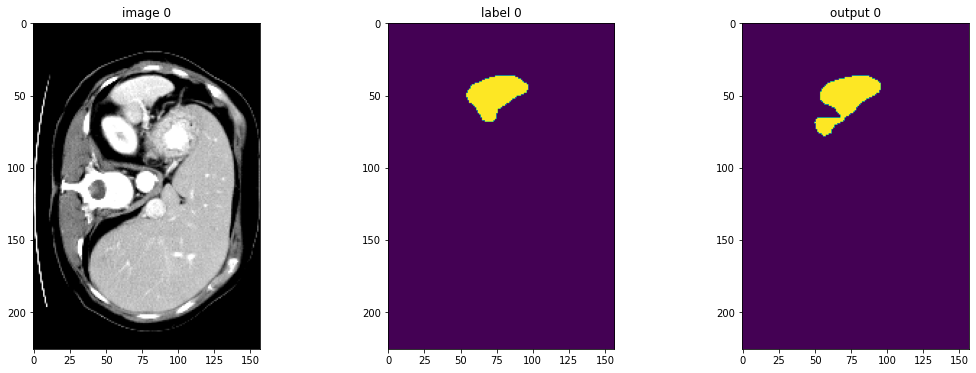

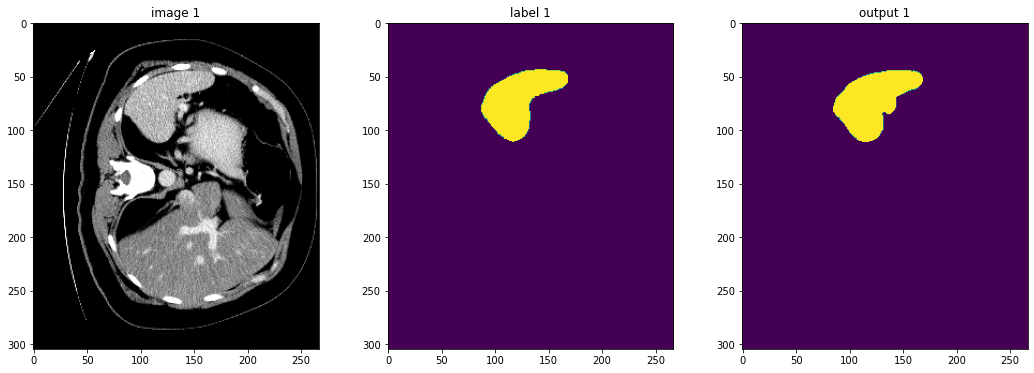

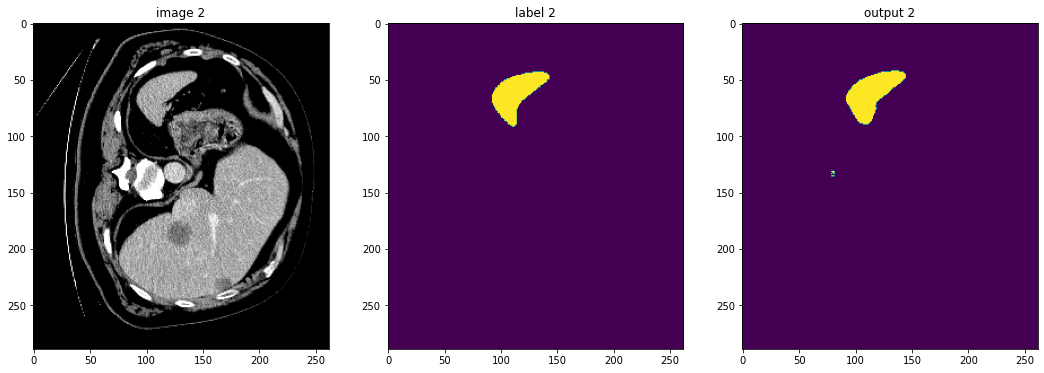

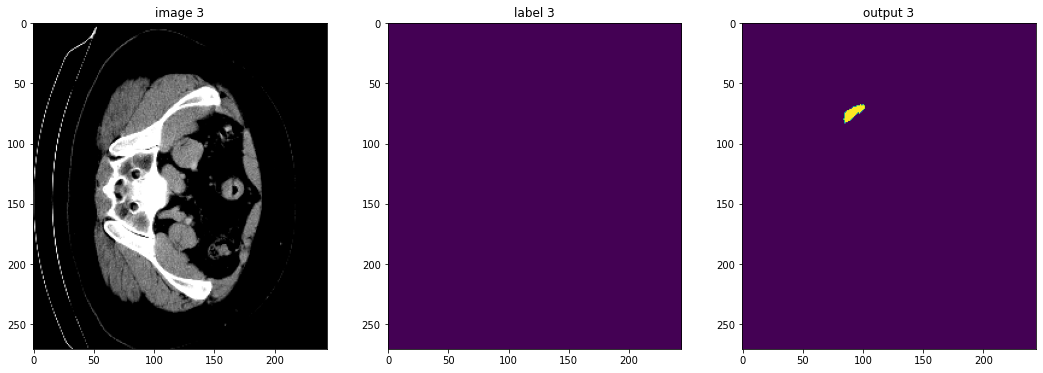

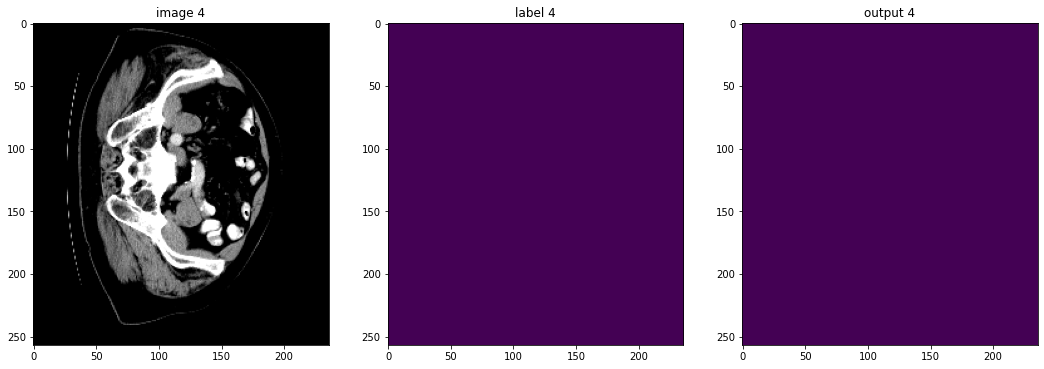

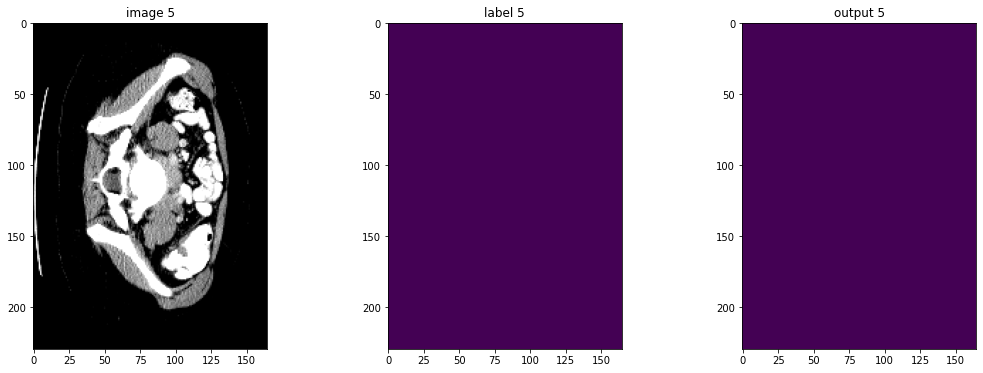

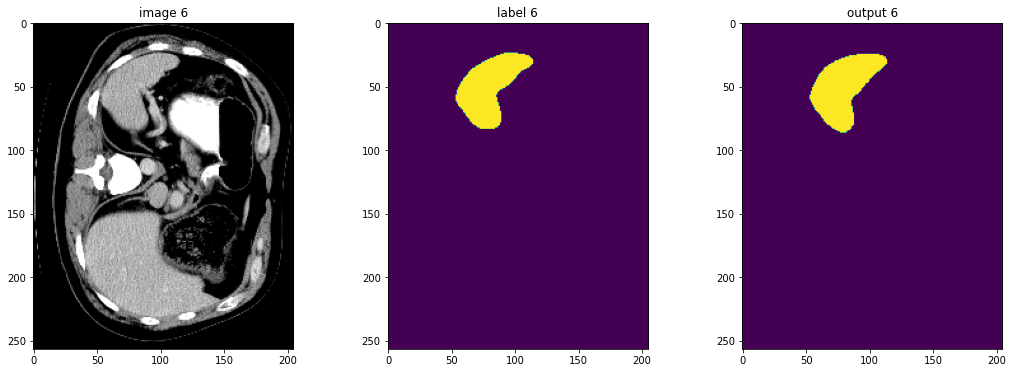

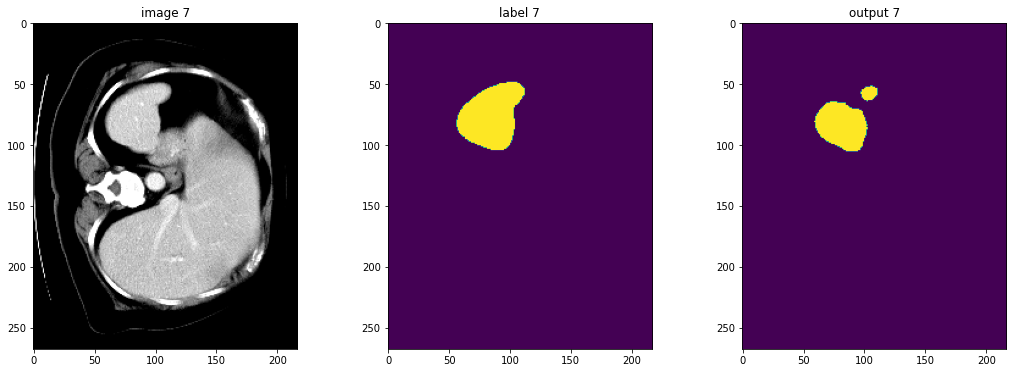

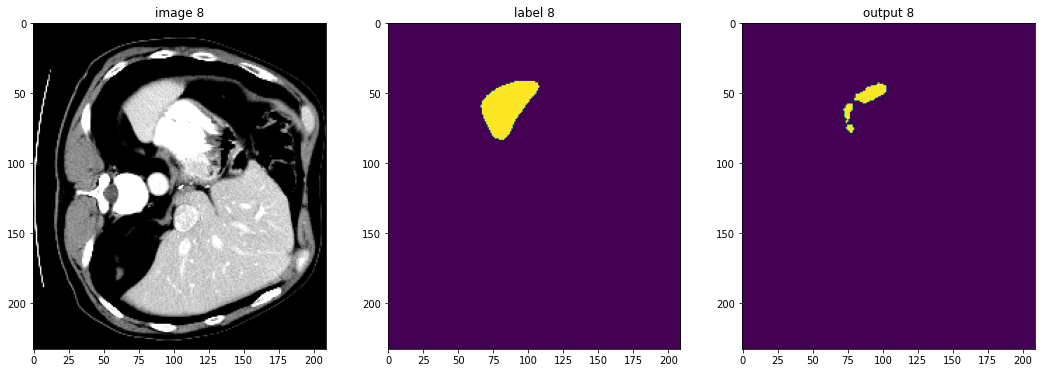

In [8]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()


## Cleanup data directory

Remove directory if a temporary was used.

In [14]:
if directory is None:
    shutil.rmtree(root_dir)